# Open EFT file
We open the file using `NanoEventsFactory` from the `coffea` package.

In [94]:
import os
import numpy as np
import awkward as ak

import vector
vector.register_awkward()

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fontsize=12
plt.style.use([hep.style.ROOT, {'font.size': fontsize}])
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'figure.figsize' : (6, 6)})

In [7]:
fname = "root://eosuser.cern.ch//eos/user/n/nfeci/Research_project_EFT/Data_EFT/ttHbb_p1j_EFT_signal_EFTcenter_madspin_tbarlnutqq_5F_fixedscale_v1/test_eft_7.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    #metadata=metadata,
).events()

/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference 

## Print file branches

In [8]:
events.fields

['GenPart',
 'LHEPart',
 'GenVisTau',
 'LHEReweightingWeight',
 'Generator',
 'LHE',
 'run',
 'genWeight',
 'LHEPdfWeight',
 'PSWeight',
 'GenMET',
 'GenIsolatedPhoton',
 'GenJet',
 'luminosityBlock',
 'HTXS',
 'GenJetAK8',
 'LHEWeight',
 'MET',
 'event',
 'GenVtx',
 'LHEScaleWeight',
 'GenDressedLepton']

## Print EFT reweighting weights
The EFT per-event weights are stored in the branch `LHEReweightingWeight`.

In [9]:
events.LHEReweightingWeight

<Array [[1.13, 2.94, 1.93, ... 1.13, 1.13]] type='3569 * [var * float32[paramete...'>

In [10]:
# Print the first weight, for all events
events.LHEReweightingWeight[:,0]

<Array [1.13, 1.14, 1.13, ... 1.13, 1.13, 1.13] type='3569 * float32[parameters=...'>

In [11]:
# Print the first weight, for the first event
events.LHEReweightingWeight[0,0]

1.1343994140625

## Important variables for EFT studies

The important branches are the generator level variables such as `GenJet`, `GenMET`, `GenPart`.

In [12]:
events.GenJet.pt

<Array [[201, 153, 73.6, ... 12.7, 12.3, 10.3]] type='3569 * var * float32[param...'>

In [13]:
events.GenPart

<GenParticleArray [[GenParticle, ... GenParticle]] type='3569 * var * genParticle'>

In [14]:
events.GenMET

<MissingETArray [MissingET, MissingET, ... MissingET] type='3569 * missingET'>

## Select Higgs from gen particles

In [15]:
is_higgs = events.GenPart.pdgId == 25 # Select Higgs bosons from GenPart
is_higgs

<Array [[False, False, ... False, False]] type='3569 * var * bool'>

In [16]:
events.GenPart[is_higgs].fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [17]:
events.GenPart[is_higgs].hasFlags(['fromHardProcess'])

<Array [[True, True, True, ... True, True]] type='3569 * var * bool'>

In [18]:
events.GenPart[is_higgs].childrenIdxG[0].tolist()

[[11], [49], [78], [149, 150]]

In [19]:
has_children = ak.num(events.GenPart[is_higgs].childrenIdxG, axis=2) == 2 # mask to consider only the GenPart with two children (the b-quarks in the decay H->bb)
has_children

<Array [[False, False, False, ... False, True]] type='3569 * var * bool'>

In [20]:
higgs = events.GenPart[is_higgs][has_children]
higgs

<GenParticleArray [[GenParticle], ... [GenParticle]] type='3569 * var * genParticle'>

In [21]:
n_higgs = ak.num(higgs)
n_higgs

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='3569 * int64'>

In [22]:
# Check that there is one and only one Higgs boson per-event
ak.all(n_higgs == 1)

True

## Inspect Higgs variables

We can already plot some kinematical distributions of the Higgs boson at generator level.

In [23]:
higgs.pt

<Array [[47.7], [42.3], ... [61], [73.8]] type='3569 * var * float32[parameters=...'>

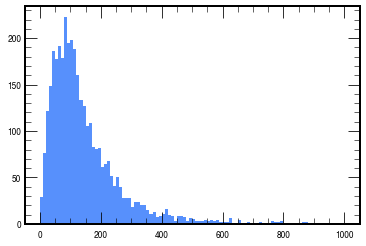

In [24]:
pt = ak.flatten(higgs.pt) # flatten the array before plotting with plt.hist()
plt.hist(pt, bins=100, range=(0, 1000));

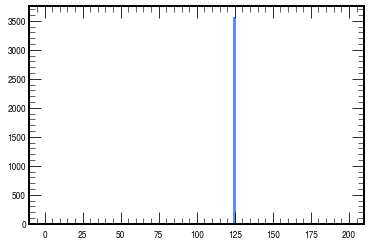

In [25]:
mass = ak.flatten(higgs.mass)
plt.hist(mass, bins=100, range=(0, 200));

## Reweigh histogram with EFT weights

We can pass the weight `events.LHEReweightingWeight` to `plt.hist()` in order to weigh the histograms with the EFT weights.

In [21]:
w0 = events.LHEReweightingWeight[:,0]
w0

<Array [1.07, 1.07, 1.07, ... 1.07, 1.07, 1.07] type='5000 * float32[parameters=...'>

## Plot of SM distribution and EFT-reweighed distribution

In order to look for EFT effects on the Higgs kinematical variables, we can plot the SM distribution and the distribution reweighed with a specific weight, to explore its on the distribution.

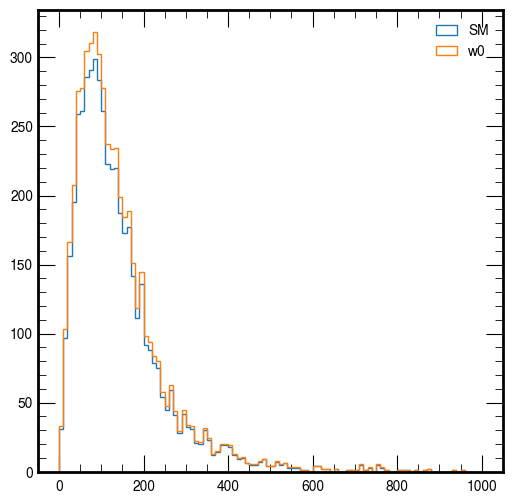

In [22]:
plt.hist(pt, bins=100, range=(0, 1000), histtype='step', label="SM")
plt.hist(pt, bins=100, range=(0, 1000), histtype='step', label="w0", weights=w0)
plt.legend();

## Inspect top variables

In [23]:
is_top = events.GenPart.pdgId == 6 # Select top quarks from GenPart
is_top

<Array [[False, False, ... False, False]] type='5000 * var * bool'>

In [24]:
has_children = ak.num(events.GenPart[is_top].childrenIdxG, axis=2) == 2 # mask to consider only the GenPart with two children
has_children

<Array [[False, False, False, ... False, True]] type='5000 * var * bool'>

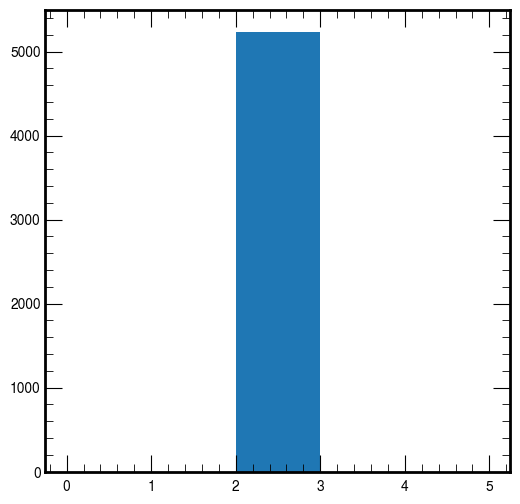

In [25]:
plt.hist(ak.flatten(ak.num(events.GenPart[is_top].childrenIdxG, axis=2)[has_children]), bins=5, range=(0,5));

In [26]:
ak.flatten(events.GenPart[is_top][has_children]).childrenIdxG[0]

<Array [593, 594] type='2 * int64'>

In [27]:
events.LHEPart.pdgId[0].tolist()

[21, 21, 4, -3, 5, 11, -12, -5, 5, -5]

In [28]:
events.GenPart[is_top].pt[0].tolist()

[178.9066162109375,
 175.6811981201172,
 175.27464294433594,
 175.47698974609375,
 175.67153930664062]

# Study decay

In [29]:
genparts = events.GenPart
hard_process = genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy']) 

In [31]:
genparts[hard_process].pdgId[0:10].tolist()

[[6, -6, 25, 5, 24, -5, -24, 5, -5, 2, -1, 11, -12],
 [-2, 6, -6, 25, 21, 5, 24, -5, -24, 5, -5, 4, -3, 11, -12],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 4, -3, 11, -12],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 2, -1, 15, -16],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 4, -3, 11, -12],
 [6, -6, 25, 21, 5, 24, -5, -24, 5, -5, 4, -3, 11, -12],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 2, -1, 13, -14],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 4, -3, 13, -14],
 [6, -6, 25, 21, 5, 24, -5, -24, 5, -5, 4, -3, 11, -12],
 [6, -6, 25, 5, 24, -5, -24, 5, -5, 2, -1, 13, -14]]

In [88]:
top = genparts[hard_process][:,0]
antitop = genparts[hard_process][:,1]  # leptonically

In [60]:
lepton = genparts[hard_process][:,-2]
quarks_fromW =  genparts[hard_process][:,-4:-2]

In [64]:
ak.argsort(quarks_fromW.pt, axis=1)

<Array [[0, 1], [0, 1], ... [0, 1], [1, 0]] type='3569 * var * int64'>

In [68]:
quark_fromW = quarks_fromW[ak.argsort(quarks_fromW.pt, axis=1, ascending=False)][:,-0]

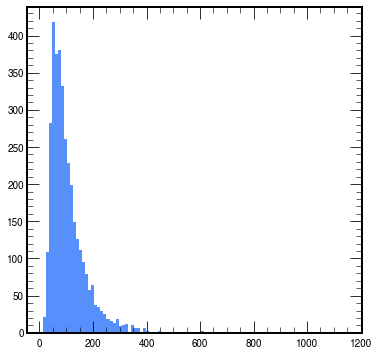

In [73]:
plt.hist(quark_fromW.pt, bins=100);

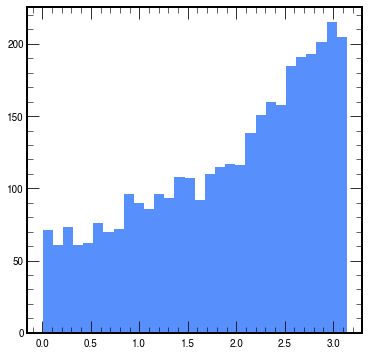

In [86]:
plt.hist(abs(lepton.delta_phi(quark_fromW)), bins=30);

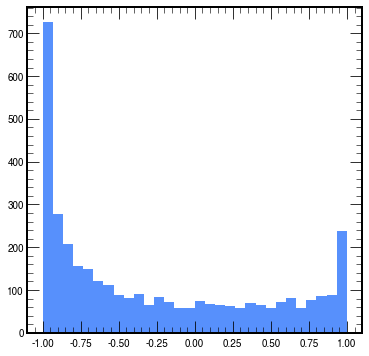

In [83]:
plt.hist(np.cos(lepton.delta_phi(quark_fromW)), bins=30);

In [ ]:
improt 

In [92]:
top.pvec

/usr/local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(
/usr/local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in multiply
  result = getattr(ufunc, method)(


<ThreeVectorArray [{x: -199, y: 142, ... z: -444}] type='3569 * ThreeVector["x":...'>

In [93]:
lepton.boost(-top.pvec)

/usr/local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


<LorentzVectorArray [{x: nan, y: nan, z: nan, ... t: nan}] type='3569 * LorentzV...'>

In [43]:
ak.local_index(genparts, axis=1)[initial]

<Array [[74, 81, 88, 93, ... 327, 328, 329]] type='3569 * var * int64'>

In [48]:
genparts[81].genPartIdxMother

<Array [-1, -1, 8, 9, ... 2307, 2314, 2316] type='2322 * int32[parameters={"__do...'>

In [37]:
ak.firsts(genparts[hard_process][:,0].children).genPartIdxMotherG

<Array [4, 685, 1752, ... 6170068, 6171228] type='3569 * ?int64[parameters={"__d...'>

In [32]:
N_genpart_event = ak.num(genparts, axis=1)
genpart_index_offset = np.concatenate([[0],np.cumsum(N_genpart_event)])
genparts_flat = ak.flatten(genparts)

def reverse_index(idxG):
    event_idx = ak.local_index(genpart_index_offset)[(genpart_index_offset-idxG) > 0][0] - 1
    genpart_idx =  idxG - genpart_index_offset[event_idx]
    return event_idx, genpart_idx

def print_tree(idxG, offset=0):
    part = genparts_flat[idxG]
    idx = reverse_index(idxG)
    
    
    if part.hasFlags(['fromHardProcess','isHardProcess', 'isPrompt', 'isFirstCopy']) and part.status!=21:
        print('+ '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
        print("         --> initial copy, hard process ", end="")
    else:
        print('| '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
    print()
    
    
    child = part.childrenIdxG
    #has_children = len(child)>0
    for partIdx in child:
        print_tree(partIdx, offset+1)
        
def print_tree_event(iev, idx):
    idxG = genpart_index_offset[iev] + idx
    print_tree(idxG)

In [51]:
print_tree_event(0,2)

pdgId:21, status:21, GenPart (0, 2), mother 7, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:0.000, eta:25712.000, phi:0.000
+ pdgId:6, status:22, GenPart (0, 4), mother 2, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:244.496, eta:1.366, phi:2.520         --> initial copy, hard process 
| | pdgId:6, status:44, GenPart (0, 9), mother 4, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:245.427, eta:1.366, phi:2.511
| | | pdgId:6, status:44, GenPart (0, 47), mother 9, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:245.487, eta:1.366, phi:2.510
| | | | pdgId:6, status:62, GenPart (0, 76), mother 47, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:245.124, eta:1.365, phi:2.511
+ + + + + pdgId:5, status:23, GenPart (0, 127), mother 76, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy: